# `BUILDING A ML MODEL TO PREDICT CUSTOMER CHURN` 
#### Using the CRISP-DM framework

## `Business Understanding`

#### Goal/Description
To create a machine learning model to predict the likelihood of retaining a customer

#### `Null Hypothesis`
There is no relationship between a tech savy customer and the customer retention

#### `Alternate Hypothesis`
There is a relationship between a tech savy customer and the customer retention

#### `Probing Questions`
- Do TV streaming customers have a higher monthly charge?
- What is the effect of online security and protection on customer retention?
- What is the relationship between customer age and the type of contract used?
- Do customers with dependents have more internet security?

## Data Understanding

#### Data Source
The data was sourced from a Telecommunication company and divided into three (3) parts :
- 3000 rows as the training data
- 2000 rows as the evaluation data 
- 2000 rows as the test data 

#### Data Exploration

In [106]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
import matplotlib.pyplot as plt
import plotly.express as px


In [60]:
#Access protocols for the SQL Database
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [61]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [62]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM LP2_Telco_churn_first_3000"

df= pd.read_sql(query, connection)
df.info()

C:\Users\chrap\AppData\Local\Temp\ipykernel_40576\3770348297.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql(query, connection)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [63]:
# Describing the Dataframe
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### OBSERVATIONS
- The dataset has a good gender balance of 51% of male and the rest being females.
- 84% of the customers are young which is expected as the younger generation are more aligned to streaming services.
- 80% are single individuals with no families.
- 

In [64]:
# Checking the Null value
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [65]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [66]:
#Dropping Empty rows
df = df.dropna(subset=['OnlineSecurity','OnlineBackup','DeviceProtection'],axis=0)


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, 0 to 2998
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2349 non-null   object 
 1   gender            2349 non-null   object 
 2   SeniorCitizen     2349 non-null   bool   
 3   Partner           2349 non-null   bool   
 4   Dependents        2349 non-null   bool   
 5   tenure            2349 non-null   int64  
 6   PhoneService      2349 non-null   bool   
 7   MultipleLines     2080 non-null   object 
 8   InternetService   2349 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          2349 non-null   object 
 16  PaperlessBilling  2349 non-null   bool   
 17  

In [68]:
#finding duplicates
duplicate = df[df.duplicated()]
duplicate.shape

(0, 21)

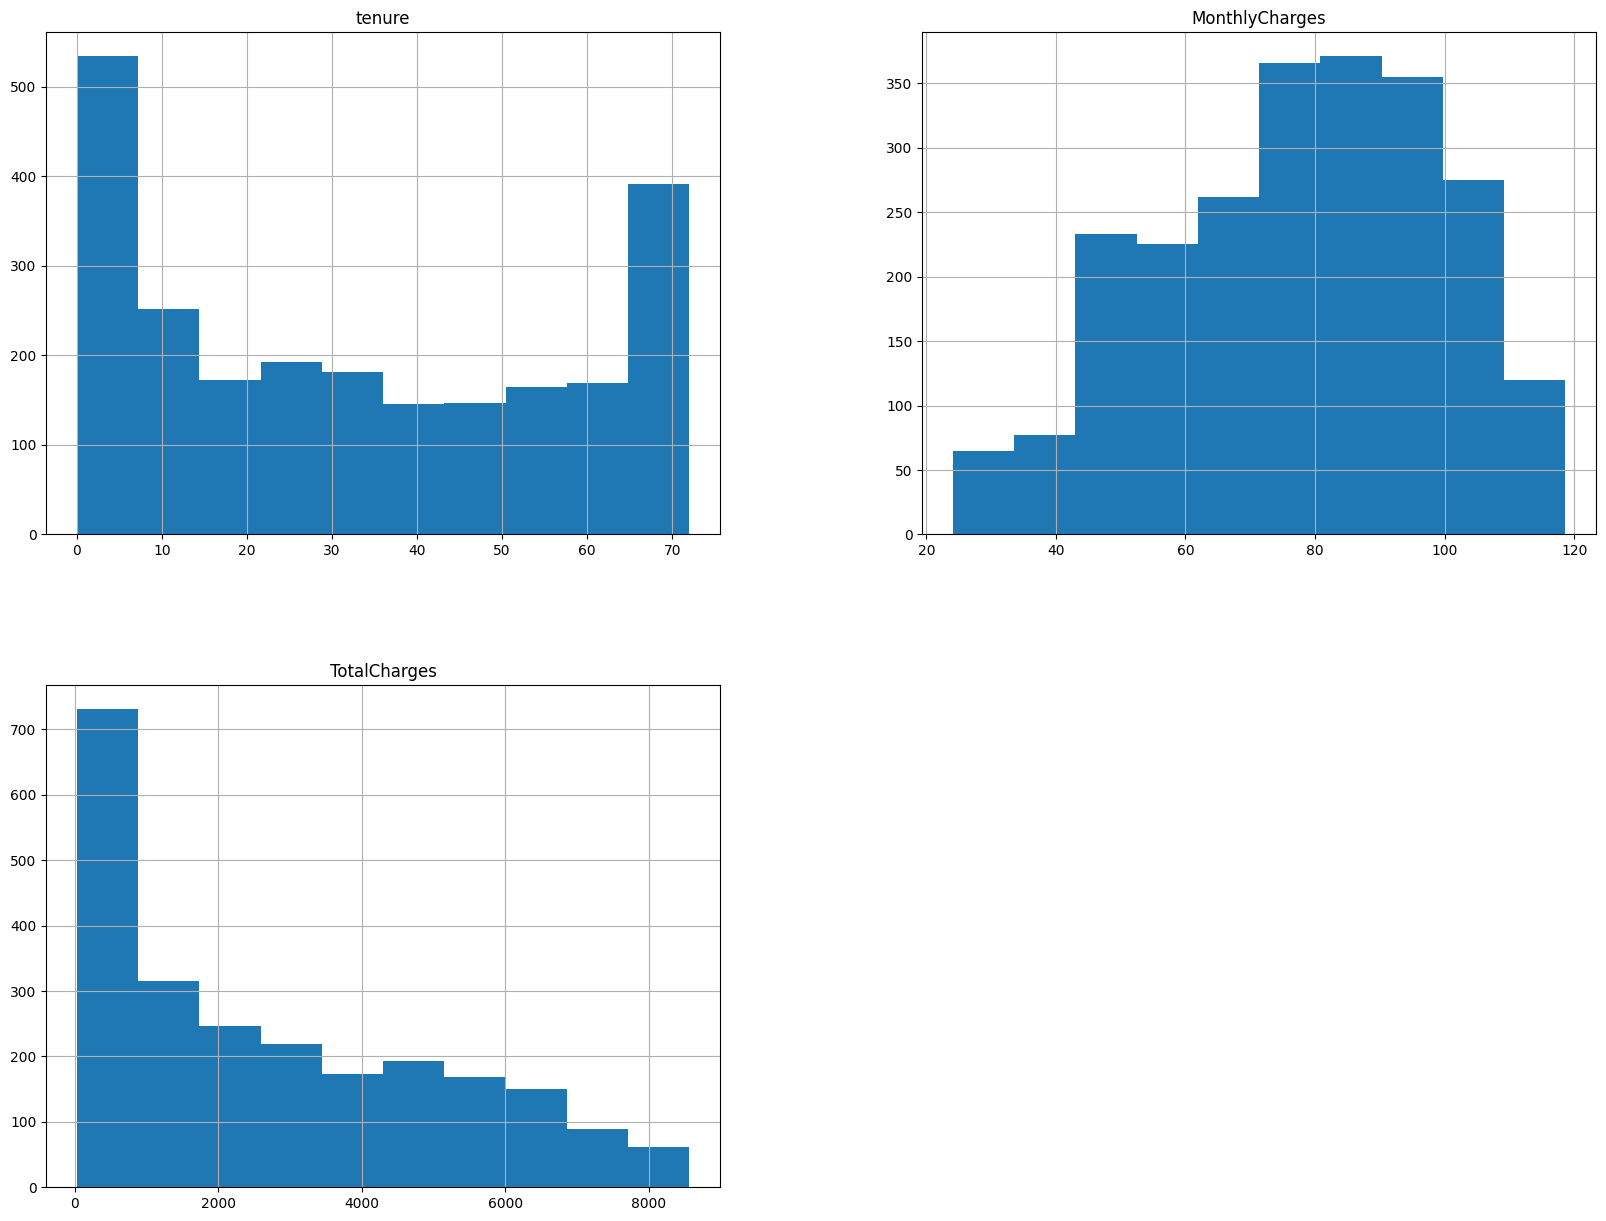

In [69]:
# Distribution of the variables
df.hist(figsize=(20, 15))
plt.show()

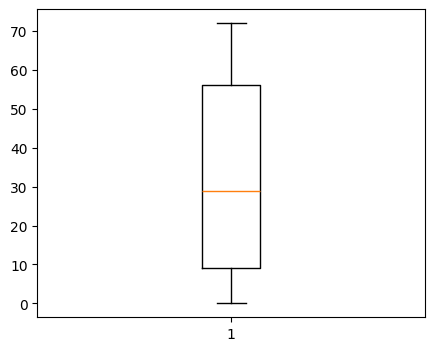

In [70]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(df.tenure)
plt.show()

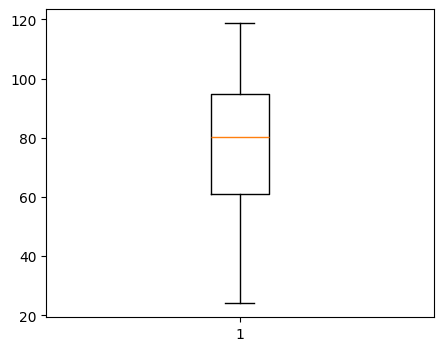

In [71]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(df.MonthlyCharges)
plt.show()

fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.bar(df.TotalCharges)
plt.show()

In [72]:
#Do TV streaming customers have a higher monthly charge?
streamers = df.groupby('StreamingTV')['MonthlyCharges'].sum()
streamers

StreamingTV
False     78696.899982
True     103558.500027
Name: MonthlyCharges, dtype: float64

<Axes: xlabel='OnlineSecurity,DeviceProtection'>

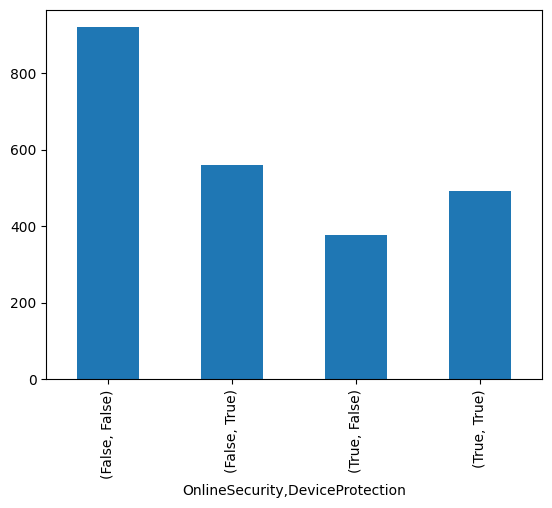

In [73]:
#What is the effect of online security and protection on customer retention?
cust_retention = df.groupby(['OnlineSecurity','DeviceProtection'])['Churn'].count()
cust_retention.plot(kind='bar')

<Axes: xlabel='Contract'>

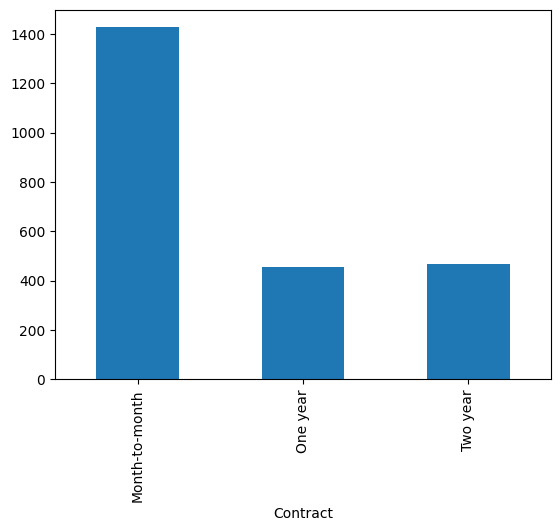

In [74]:
#What is the relationship between customer age and the type of contract used?
cust_contract = df.groupby('Contract')['SeniorCitizen'].count()
cust_contract.plot(kind='bar')

OnlineSecurity
False    1478
True      871
Name: Dependents, dtype: int64

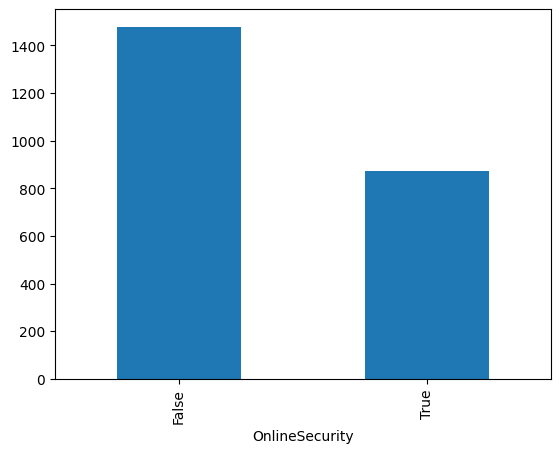

In [75]:
#Do customers with dependents have more internet security?
cust_contract = df.groupby('OnlineSecurity')['Dependents'].count()
cust_contract.plot(kind='bar')
cust_contract

In [76]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [107]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.10f" % p_value_normality)
    if p_value_normality <0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [110]:
#Hypothesis
#There is no relationship between a tech savy customer and the customer retention
##
#
###
###
df_tech= df.loc[df.OnlineSecurity & df.DeviceProtection]
online=df.loc[df.OnlineSecurity]
device= df.loc[df.DeviceProtection]


df_tech

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
14,5129-JLPIS,Male,False,False,False,25,True,False,Fiber optic,True,...,True,True,True,True,Month-to-month,True,Electronic check,105.500000,2686.050049,False
15,3655-SNQYZ,Female,False,True,True,69,True,True,Fiber optic,True,...,True,True,True,True,Two year,False,Credit card (automatic),113.250000,7895.149902,False
17,9959-WOFKT,Male,False,False,True,71,True,True,Fiber optic,True,...,True,False,True,True,Two year,False,Bank transfer (automatic),106.699997,7382.250000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,9443-JUBUO,Male,False,True,True,72,False,None,DSL,True,...,True,True,True,True,Two year,True,Credit card (automatic),65.250000,4478.850098,False
2983,4674-HGNUA,Male,False,True,True,71,True,True,DSL,True,...,True,True,True,True,Two year,False,Credit card (automatic),89.900002,6457.149902,False
2985,9786-IJYDL,Female,False,False,False,35,True,True,Fiber optic,True,...,True,True,True,True,Two year,True,Mailed check,113.199997,3914.050049,False
2988,6295-OSINB,Male,False,True,False,72,True,True,Fiber optic,True,...,True,False,True,True,Two year,True,Electronic check,109.650002,7880.250000,None


In [112]:
check_normality(df_tech.TotalCharges,'Online Security and Device Protection')
check_normality(online.TotalCharges,'Online Security')
check_normality(device.TotalCharges,'Device Protection')

p value:1.0000000000
Fail to reject null hypothesis >> The data for Online Security and Device Protection is normally distributed
p value:1.0000000000
Fail to reject null hypothesis >> The data for Online Security is normally distributed
p value:1.0000000000
Fail to reject null hypothesis >> The data for Device Protection is normally distributed


In [118]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges )

print("p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:nan
Fail to reject null hypothesis >> The variances of the samples are same.


#### Observation 
-Data is normally distributed
- Parametric test can be done

In [ ]:
#ANOVA test 

#### Observation
No duplicates

In [79]:
## Data preparation
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,8046-DNVTL,Male,False,True,False,62,False,None,DSL,True,...,False,True,False,False,Two year,True,Credit card (automatic),38.599998,2345.550049,False
2995,2209-XADXF,Female,False,False,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,False,Bank transfer (automatic),25.250000,25.250000,False
2996,6620-JDYNW,Female,False,False,False,18,True,True,DSL,True,...,True,False,False,False,Month-to-month,True,Mailed check,60.599998,1156.349976,False
2997,1891-FZYSA,Male,True,True,False,69,True,True,Fiber optic,False,...,False,False,True,False,Month-to-month,True,Electronic check,89.949997,6143.149902,True


In [80]:
deff = df.drop('customerID',axis=1)
deff.corr()

ValueError: could not convert string to float: 'Female'

In [ ]:
## Modeling

In [ ]:
## Evaluation

### Data Understainding

Data Understanding typically involves the following steps:

- Determine what data is needed and collect the data if not available
- Explore data
- Verify data quality

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

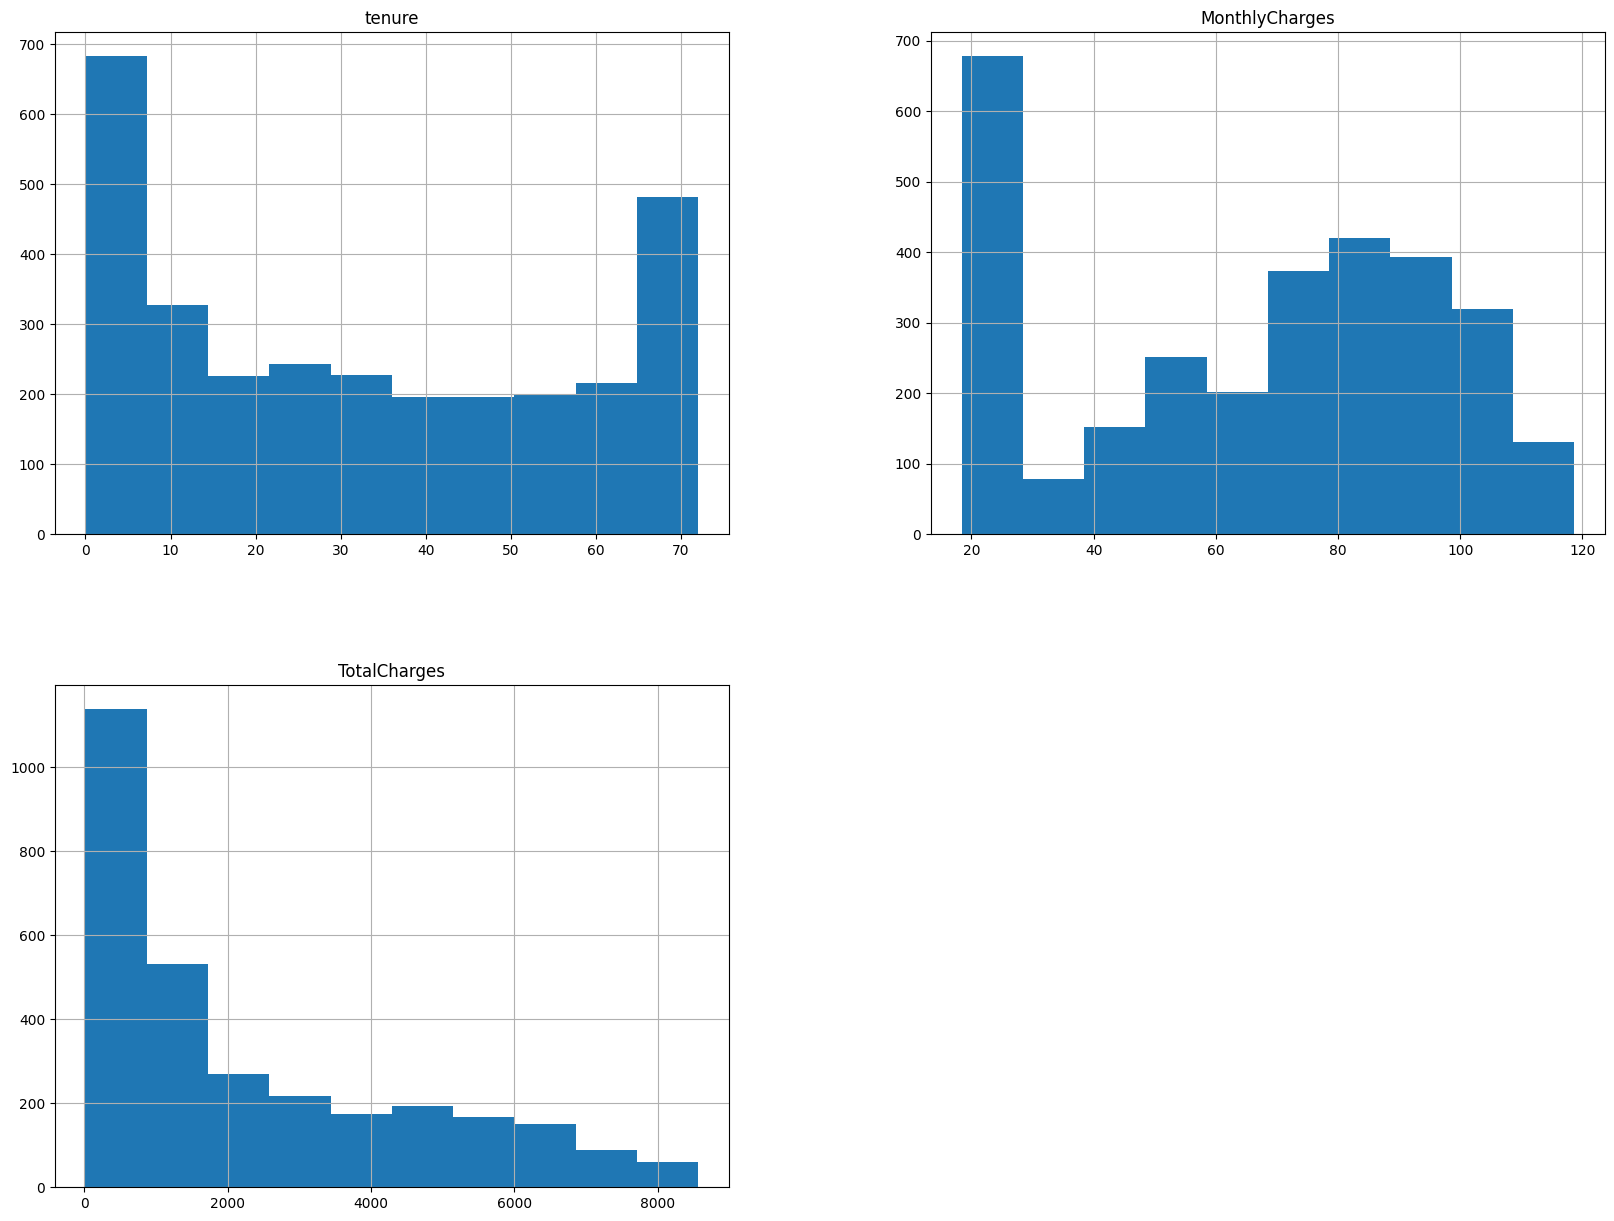

In [ ]:
# Distribution of the variables
data.hist(figsize=(20, 15))

### EDA 
#### Visualizing Characteristics of the Dataset

In [ ]:
monthly_charges=(data.groupby('PaymentMethod',sort=True)['TotalCharges'].sum())
fig=px.bar(monthly_charges,y='TotalCharges')#,color ='PaymentMethod',text='PaymentMethod',labels={'PaymentMethod':'Sum of charges(Lahks/1000)'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed